**извлечение признаков из текста на естественном языке**

кластеризатор текстов

частотный анализ с очисткой стоп-слов (TF)

Евгений Борисов borisov.e@solarl.ru

## библиотеки

In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# from sklearn.metrics import accuracy_score

In [3]:
%matplotlib inline

In [4]:
pd.options.display.max_colwidth = 200  

## тексты

In [5]:
# загружаем тексты
data = pd.read_pickle('../data/text/news.pkl.gz')
print('записей:',len(data))

записей: 3196


In [6]:
data.sample(2)

,text,tag
318,На Марата Гельмана подали в суд за оскорбление религиозных чувств (3)В\nЗамоскворецком суде Москвы началось рассмотрение иска девяти столичных\nхудожников против Галереи Марата Гельмана и Централь...,culture
2707,"Планируется, что ноутбук будет работать после попадания в воду, при температуре воздуха от -50 до 50 °С, а также после сильных ударов и вибраций.\n\n«Защищенные ноутбуки могут использоваться в ком...",tech


---

In [7]:
# from nltk import download as nltk_download
# nltk_download('stopwords')

In [8]:
# from Stemmer import Stemmer

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords

stopwords = set(nltk_stopwords.words('russian') )

In [9]:
%%time 

data['text_clean'] = data['text'].str.lower() # приведение в lowercase

# замена символов-разделителей (-,_) на пробел
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'\W', ' ', s))
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'_', ' ', s))

# замена цифр
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'\b\d+\b', ' ', s))

# делим строки на слова (токенизация)
data['text_clean'] = data['text_clean'].apply(lambda t: [ w.strip() for w in t.split() if len(w.strip())>2 ] )

# удаление лишних слов 
data['text_clean'] = data['text_clean'].apply(lambda t:[w for w in t if w not in stopwords])

# стемминг, выделение основы слова
# data['text_clean'] = data['text_clean'].apply( lambda t: Stemmer('russian').stemWords(t) )
data['text_clean'] = data['text_clean'].apply(lambda t:[ SnowballStemmer('russian').stem(w) for w in t if w])


CPU times: user 57.9 s, sys: 127 ms, total: 58 s
Wall time: 58.3 s


In [10]:
data['text_clean'] = data['text_clean'].apply(lambda t:' '.join(t))

In [11]:
data[['text_clean']].sample(2)

,text_clean
166,гандбольн сборн росс чемпионат мир обыгра кита сборн росс перв матч разгром команд уругв втор игр доб побед сборн кит счет сопротивлен соперниц команд евген трефилов преодолел втор тайм
3086,департамент межнациональн отношен министерств региональн разв сми2 smi2 ден крещен рус определ цивилизацион пут развит стран введен росс нов памятн дат дня крещен рус эт преференц русск православн...


##  CountVectorizer + TF

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
tf = TfidfVectorizer(use_idf=True,norm='l2')
# tf = TfidfVectorizer(use_idf=False,norm='l2')

tf.fit( data['text_clean'] )

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [14]:
len(tf.vocabulary_)

34887

## формируем датасет

In [15]:
X = tf.transform( data['text_clean'] )
X.shape

(3196, 34887)

## обучаем

In [16]:
from sklearn.cluster import KMeans

In [17]:
%%time

n_clusters = len(set(data['tag']))
clust = KMeans(n_clusters=n_clusters, random_state=622 )
clust.fit(X)

CPU times: user 2min 22s, sys: 384 ms, total: 2min 22s
Wall time: 2min 26s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=622, tol=0.0001, verbose=0)

In [18]:
data['cluster'] = clust.labels_

## тестируем

In [19]:
from matplotlib import pyplot as plt

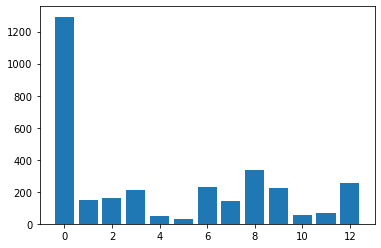

In [20]:
# размеры кластеров
b = [ (data['cluster']==c).sum() for c in range(n_clusters) ]
plt.bar(range(len(b)),b)
plt.show()

In [21]:
data[ data['cluster']==0 ][['text','tag']].sample(10)

,text,tag
1194,Минчане пожаловались в прокуратуру на администрацию Советского района\n\n28 ноября 2016 в 14:29\n\nЕлена Толкачева / REALTY.TUT.BY\n\nИнициативная группа жителей Советского района направила в райо...,realty
236,"Шедевры Пушкинского музея уже в Москве В Москву прибыл первый из четырех\nгрузовиков с картинами из коллекции Государственного музея изобразительных\nискусств имени Пушкина, задержанными более нед...",culture
926,"Правозащитники Amnesty International призывают не допустить казни ""последнего белорусского смертника""\n\n9 декабря 2016 в 14:38\n\nБелаПАН / TUT.BY\n\nПравозащитная организация Amnesty Internation...",social
2471,"Вашингтон, , 08:42 — REGNUM Пятилетний мальчик, страдавший смертельным недугом, скончался в объятьях Санта-Клауса в американском штате Теннеси. Ребенок боялся, что не успеет дожить до Рождества и ...",culture
2233,"Подростка записали на прием к кардиологу, но попасть к врачу парень не успел Фото: Личная страничка героя публикации в соцсети\n\nРегиональны следком возбуждено уголовное дело после смерти 16-летн...",incident
703,"Песни Мулявина, вышиванки и победитель из провинции. В Dozari прошел ""Студент года"" от БРСМ\n\n9 декабря 2016 в 12:52\n\nМайя Кохно / Фото: Евгений Ерчак / TUT.BY\n\nВ четверг, 8 декабря, в столич...",politics
1351,"Новые Android-смартфоны Nokia появятся в начале 2017 года\n\n1 декабря 2016 в 15:56\n\n42.TUT.BY\n\nКомпания Nokia объявила о завершении сделки с HMD Global, которая получает права на производство...",tech
617,"Крылья, ноги и бюстгальтер за три миллиона: как прошло шоу Victoria's Secret в Париже\n\n4 декабря 2016 в 9:27\n\nГазета.Ru\n\nВ конце ноября в Париже прошел секретный показ Victoria’s Secret — са...",woman
153,"США помогут Китаю минимизировать ущерб от отравления реки Сунгари Как\nуже сообщало ИА REGNUM , Пекин ранее извинился за загрязнение Сунгари\nнитробензолом в результате аварии на химическом заводе...",health
661,"Конференция для тех, кого заботит безопасность дочерей\n\n2 декабря 2016 в 9:00\n\nPR-служба TUT.BY\n\nАктовый зал заполнен школьницами четвертых, пятых, шестых классов.\n\n— Поднимите, пожалуйста...",social


In [22]:
data[ data['cluster']==1 ][['text','tag']].sample(10)

,text,tag
1963,"Человеком года по версии авторитетной американской газеты Financial Times стал избранный президент США Дональд Трамп, триумф которого на выборах главы государства был крайне неожиданным, а его пер...",politics
1384,"Избранный президент США Дональд Трамп позвонил бывшему кандидату в американские президенты в 2008 году Митту Ромни, уведомив, что тот не рассматривается в качестве кандидата на пост госсекретаря. ...",politics
1431,"Во вторник, 13 декабря, в СМИ появилась информация, что Национальная разведка США не поддерживает оценок Центрального разведывательного управления (ЦРУ), согласно которым российские власти якобы о...",politics
1601,Фото: EPA\n\nАмериканский предприниматель и избранный президент США Дональд Трамп заявил о намерении уйти из бизнеса до получения президентских полномочий. Об этом он сообщил через Twitter. Он нам...,politics
1920,"Президент США Барак Обама арендовал офис в здании Всемирного фонда дикой природы (WWF) в Вашингтоне, сообщает газета Washington Post со ссылкой на источники. О заключении соглашения об аренде пока...",politics
1949,"Пересчет голосов в Висконсине принес Трампу еще 131 голос. Это о его противниках сказано: как считали -веселились, подсчитали - прослезились",politics
1946,Пересчет голосов в американском штате Висконсин подтвердил победу Дональда Трампа на выборах президента США. Он обошел свою соперницу — демократического кандидата Хиллари Клинтон — на 22 тысячи го...,politics
443,"""Президент Разделенных Штатов Америки"". ""Человеком года"" по версии Time стал Дональд Трамп\n\nопубликовано: 7 декабря 2016 в 15:40\n\nобновлено: 7 декабря 2016 в 18:32\n\nTUT.BY\n\nТрадиционно в д...",politics
1383,"Экс-кандидат в президенты США от республиканцев Митт Ромни выбыл из списка претендентов на пост госсекретаря в администрации Дональда Трампа.\r\n\r\n\r\nПо информации телеканала CNN, миллиардер со...",politics
1960,"Фотогалерея Президент Трамп: как миллиардер стал хозяином Белого дома\n\nДональд Трамп станет президентом США. Официальные итоги еще не подведены, однако Хиллари Клинтон уже позвонила ему и призна...",politics


In [23]:
data[ data['cluster']==3 ][['text','tag']].sample(10)

,text,tag
547,"На трассе М6 авария с тяжелыми последствиями: VW Golf въехал в поворачивающий МАЗ\n\n5 декабря 2016 в 9:43\n\nAUTO.TUT.BY\n\nВ воскресенье, 4 декабря, на трассе М6 VW Golf въехал в МАЗ. Легковушка...",incident
2258,"Более 20 солдат были ранены в результате взрыва, произошедшего во вторник на военной базе в Южной Корее. Об этом сообщает агентство ""Рёнхап"".\n\nИнцидент произошел в городе Ульсан, расположенном в...",incident
2323,"Сотрудница межмуниципального управления МВД России «Серпуховское», находившаяся за рулем в пьяном виде, насмерть сбила двоих человек в Подмосковье.\n\nПо информации главного управления МВД по Моск...",incident
2186,"Главная\n\n»\n\nНовости\n\n»\n\nТранспорт\n\nВрачи скорой помощи и сотрудники МЧС теперь сами нуждаются в помощи из-за наезда КАМАЗа\n\nБригада скорой помощи, два спасателя и двое автомобилистов г...",incident
2325,"Установлены личности пешеходов, погибших в результате наезда сотрудницы полиции в Серпухове. Погибшими оказались супруги Виталий и Елена Ш.\n\nФото: vk.com\n\nПо факту нарушения ПДД, повлекшего по...",incident
2343,"13 декабря 2016, 01:56\n\nСемья из трех человек погибла в результате отравления газом в Ростове-на-Дону\n\nУгарный газ скопился во время работы отопительного котла при замусоренном дымоходе, заяви...",incident
2184,В Кемеровской области полицейские устанавливают обстоятельства серии ДТП с участием 9 автомобилей.\n\n\n\n\n\n\n\n«Сегодня около 11:00 с небольшими временными интервалами на 106-м км дороги первой...,incident
1221,В Минске водитель Mercedes дрифтовал на площадке перед монументом Победы. Возбуждено уголовное дело\n\n6 декабря 2016 в 17:55\n\nБелаПАН\n\nПрокурор Партизанского района Минска Сергей Борисенко 6 ...,auto
2312,"Сотрудница полиции, которая на своем автомобиле сбила насмерть двух пешеходов в Серпухове, уволена со службы в органах внутренних дел по отрицательным мотивам. Об этом сообщила официальный предста...",incident
1260,"Пять скандальных случаев с участием нетрезвых сотрудников милиции за рулем\n\n28 ноября 2016 в 18:57\n\nАнастасия Солонович, Naviny.by\n\nВ Ляховичском районе в эти выходные пьяный и. о. начальник...",auto
